# ResNet-152:

In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152
from tensorflow.keras import layers, models

# Assuming dataset_folder is defined and points to your dataset directory
dataset_folder = 'C:\\Users\\Alexandra\\Documents\\SPRING_2024\\BMEN_689\\Project_2\\Jupyter_Notebook\\With_Pre_Processing\\New512by512\\'

# Function to split dataset into train/validation/test
def split_dataset(data_folder, train_size=0.6, val_size=0.2, test_size=0.2):
    for class_folder in os.listdir(data_folder):
        class_path = os.path.join(data_folder, class_folder)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            train_files, test_files = train_test_split(files, test_size=val_size+test_size, random_state=42)
            val_files, test_files = train_test_split(test_files, test_size=test_size/(val_size+test_size), random_state=42)

            train_folder = os.path.join(data_folder, 'train', class_folder)
            val_folder = os.path.join(data_folder, 'validation', class_folder)
            test_folder = os.path.join(data_folder, 'test', class_folder)
            for folder in [train_folder, val_folder, test_folder]:
                if not os.path.exists(folder):
                    os.makedirs(folder)

            for file in train_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(train_folder, file))
            for file in val_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(val_folder, file))
            for file in test_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(test_folder, file))

# Call the function to split the dataset
split_dataset(dataset_folder)

input_shape = (512, 512, 3)  # Use 3 channels for RGB images
num_classes = 3

# Reset the model
tf.keras.backend.clear_session()

# Load ResNet152 as the base model
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Create the model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define directory paths for data generators
train_dir = os.path.join(dataset_folder, 'train')
validation_dir = os.path.join(dataset_folder, 'validation')

# Setup data generators
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

batch_size = 16
target_size = (512, 512)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,  
    verbose=1  # Set verbose to 1 to see the training progress
)

Found 180 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Epoch 1/10
11/11 [==============================] - 35s 3s/step - loss: 1.5033 - accuracy: 0.4939 - val_loss: 0.6106 - val_accuracy: 0.7500
Epoch 2/10
11/11 [==============================] - 30s 3s/step - loss: 0.6912 - accuracy: 0.7073 - val_loss: 0.7292 - val_accuracy: 0.6875
Epoch 3/10
11/11 [==============================] - 30s 3s/step - loss: 0.4760 - accuracy: 0.7805 - val_loss: 0.1129 - val_accuracy: 0.9792
Epoch 4/10
11/11 [==============================] - 30s 3s/step - loss: 0.2424 - accuracy: 0.8902 - val_loss: 0.0815 - val_accuracy: 1.0000
Epoch 5/10
11/11 [==============================] - 30s 3s/step - loss: 0.1712 - accuracy: 0.9451 - val_loss: 0.0763 - val_accuracy: 0.9792
Epoch 6/10
11/11 [==============================] - 30s 3s/step - loss: 0.1588 - accuracy: 0.9512 - val_loss: 0.0853 - val_accuracy: 1.0000
Epoch 7/10
11/11 [==============================] - 30s 3s/step - loss: 0.1192 

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 16, 16, 2048)      58370944  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 59421571 (226.68 MB)
Trainable params: 1050627 (4.01 MB)
Non-trainable params: 58370944 (222.67 MB)
________

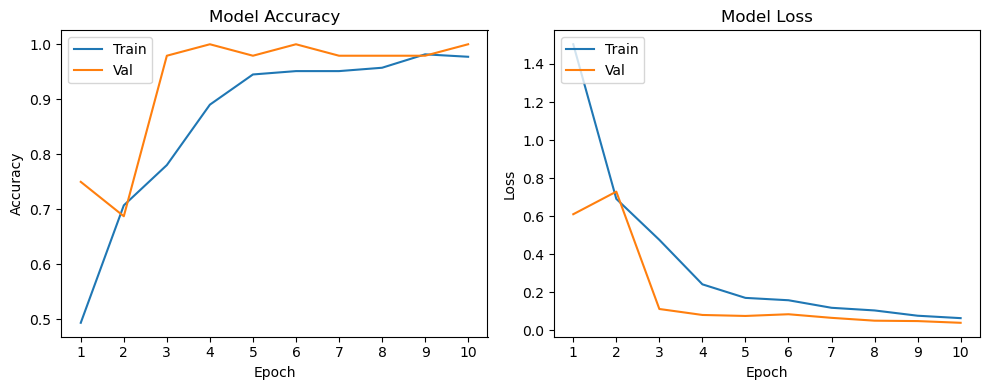

In [9]:
import matplotlib.pyplot as plt

num_epochs = len(history.history['accuracy'])

# Create an epoch count that starts at 1
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(1, num_epochs + 1))  # Set x-axis ticks from 1 to num_epochs
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(range(1, num_epochs + 1))  # Set x-axis ticks from 1 to num_epochs
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

Found 60 images belonging to 3 classes.
4/4 [==============================] - 10s 2s/step


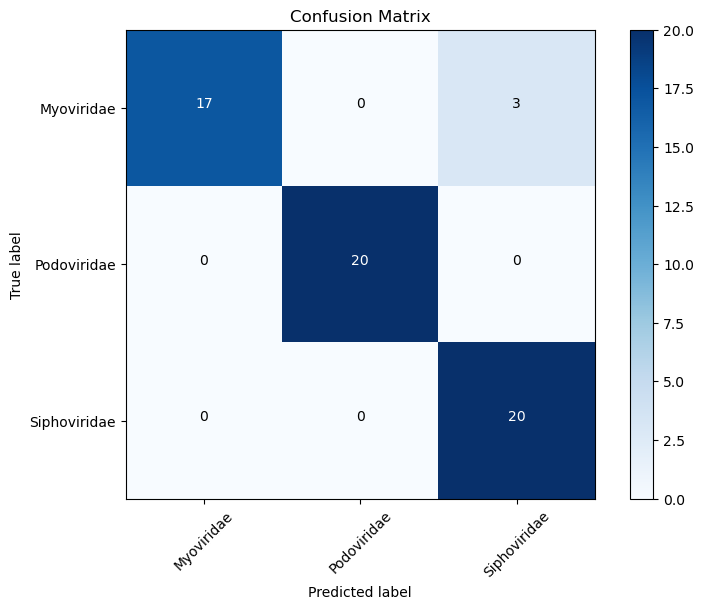

3/3 [==============================] - 7s 2s/step - loss: 0.2691 - accuracy: 0.9375
Test accuracy: 0.9375


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator

# Assuming you have already defined your model and other parameters

# Load the test set
test_dir = os.path.join(dataset_folder, 'test')
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False)  # Set shuffle to False to ensure correct order

# Evaluate the model
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = list(test_generator.class_indices.keys())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_accuracy)

In [11]:
# Print filenames of misclassified images
misclassified_images = []
for i in range(len(true_classes)):
    if predicted_classes[i] != true_classes[i]:
        filename = test_generator.filenames[i]
        misclassified_images.append((filename, predicted_classes[i], true_classes[i]))

print("Misclassified Images:")
for filename, predicted_class, true_class in misclassified_images:
    print(f"Filename: {filename}, Predicted Class: {predicted_class}, True Class: {true_class}")

Misclassified Images:
Filename: Myoviridae\16NewCombined.png, Predicted Class: 2, True Class: 0
Filename: Myoviridae\20NewCombined.png, Predicted Class: 2, True Class: 0
Filename: Myoviridae\79NewCombined.png, Predicted Class: 2, True Class: 0


# VGG19:

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models

# Assuming dataset_folder is defined and points to your dataset directory
dataset_folder = 'C:\\Users\\Alexandra\\Documents\\SPRING_2024\\BMEN_689\\Project_2\\Jupyter_Notebook\\With_Pre_Processing\\New512by512\\'

# Function to split dataset into train/validation/test
def split_dataset(data_folder, train_size=0.6, val_size=0.2, test_size=0.2):
    for class_folder in os.listdir(data_folder):
        class_path = os.path.join(data_folder, class_folder)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            train_files, test_files = train_test_split(files, test_size=val_size+test_size, random_state=42)
            val_files, test_files = train_test_split(test_files, test_size=test_size/(val_size+test_size), random_state=42)

            train_folder = os.path.join(data_folder, 'train', class_folder)
            val_folder = os.path.join(data_folder, 'validation', class_folder)
            test_folder = os.path.join(data_folder, 'test', class_folder)
            for folder in [train_folder, val_folder, test_folder]:
                if not os.path.exists(folder):
                    os.makedirs(folder)

            for file in train_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(train_folder, file))
            for file in val_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(val_folder, file))
            for file in test_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(test_folder, file))

# Call the function to split the dataset
split_dataset(dataset_folder)

input_shape = (512, 512, 3)  # Use 3 channels for RGB images
num_classes = 3

# Reset the model
tf.keras.backend.clear_session()

# Load VGG19 as the base model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Create the model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define directory paths for data generators
train_dir = os.path.join(dataset_folder, 'train')
validation_dir = os.path.join(dataset_folder, 'validation')

# Setup data generators
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

batch_size = 16
target_size = (512, 512)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,  
    verbose=1  # Set verbose to 1 to see the training progress
)





Found 180 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Epoch 1/10


11/11 [==============================] - 29s 3s/step - loss: 1.5464 - accuracy: 0.4634 - val_loss: 0.7761 - val_accuracy: 0.7083
Epoch 2/10
11/11 [==============================] - 28s 3s/step - loss: 0.6205 - accuracy: 0.7988 - val_loss: 0.2973 - val_accuracy: 0.8750
Epoch 3/10
11/11 [==============================] - 29s 3s/step - loss: 0.4132 - accuracy: 0.8415 - val_loss: 0.2659 - val_accuracy: 0.9167
Epoch 4/10
11/11 [==============================] - 29s 3s/step - loss: 0.3125 - accuracy: 0.8902 - val_loss: 0.1348 - val_accuracy: 0.9792
Epoch 5/10
11/11 [==============================] - 28s 3s/step - loss: 0.2098 - accuracy: 0.9268 - val_loss: 0.1813 - val_accuracy: 0.9375
Epoch 6/10
11/11 [==============================] - 28s 3s/step - loss: 0.2539 - accuracy: 0.8780 - val_loss: 0.2122 - val_accuracy: 0.9583
Epoch 7/10
11/11 [==============================] - 28s 3s/step - loss: 0

In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 16, 16, 512)       20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 20288579 (77.39 MB)
Trainable params: 264195 (1.01 MB)
Non-trainable params: 20024384 (76.39 MB)
___________

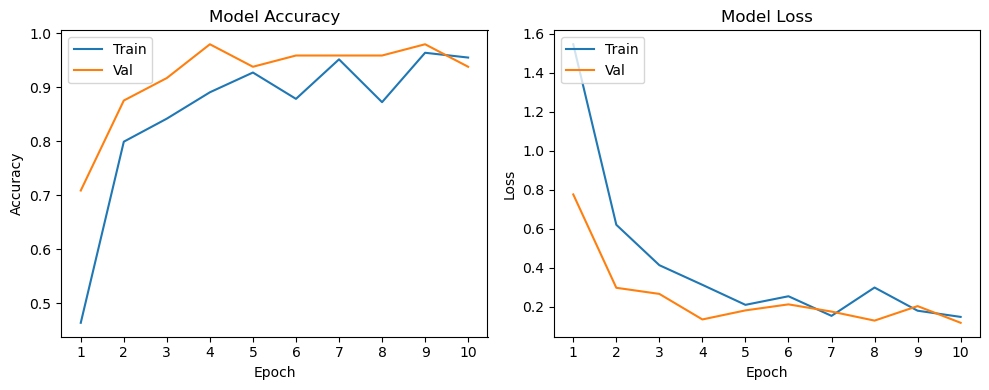

In [3]:
import matplotlib.pyplot as plt

num_epochs = len(history.history['accuracy'])

# Create an epoch count that starts at 1
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(1, num_epochs + 1))  # Set x-axis ticks from 1 to num_epochs
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(range(1, num_epochs + 1))  # Set x-axis ticks from 1 to num_epochs
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

Found 60 images belonging to 3 classes.
4/4 [==============================] - 8s 2s/step


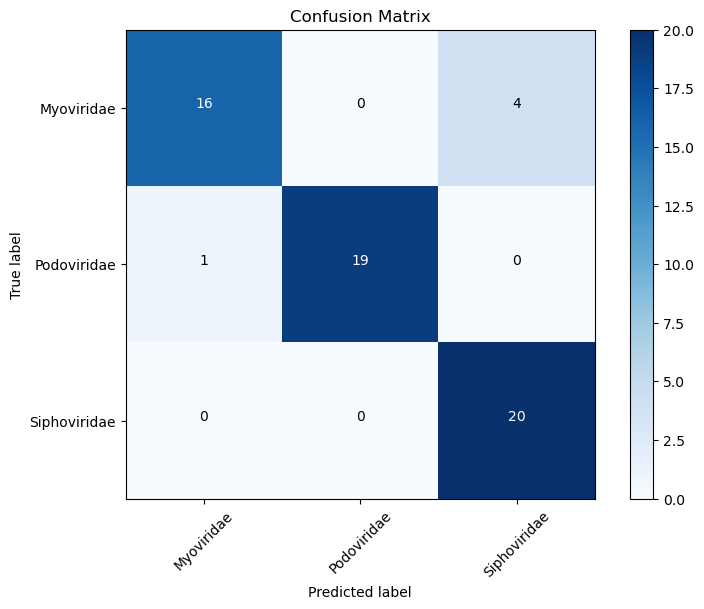

3/3 [==============================] - 6s 2s/step - loss: 0.4783 - accuracy: 0.8958
Test accuracy: 0.8958333134651184


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator

# Assuming you have already defined your model and other parameters

# Load the test set
test_dir = os.path.join(dataset_folder, 'test')
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False)  # Set shuffle to False to ensure correct order

# Evaluate the model
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = list(test_generator.class_indices.keys())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_accuracy)

In [6]:
# Print filenames of misclassified images
misclassified_images = []
for i in range(len(true_classes)):
    if predicted_classes[i] != true_classes[i]:
        filename = test_generator.filenames[i]
        misclassified_images.append((filename, predicted_classes[i], true_classes[i]))

print("Misclassified Images:")
for filename, predicted_class, true_class in misclassified_images:
    print(f"Filename: {filename}, Predicted Class: {predicted_class}, True Class: {true_class}")

Misclassified Images:
Filename: Myoviridae\10NewCombined.png, Predicted Class: 2, True Class: 0
Filename: Myoviridae\16NewCombined.png, Predicted Class: 2, True Class: 0
Filename: Myoviridae\36NewCombined.png, Predicted Class: 2, True Class: 0
Filename: Myoviridae\79NewCombined.png, Predicted Class: 2, True Class: 0
Filename: Podoviridae\36NewCombined.png, Predicted Class: 0, True Class: 1
